In [90]:
import tensorflow as tf
import librosa
import numpy as np

In [ ]:
model = tf.keras.models.load_model("yyy.h5")

In [126]:
# === CQT Configuration ===
hop_length_sec = 0.01               # 10 ms
fmin = librosa.note_to_hz('A0')     # Start at A0 (piano)
bins_per_octave = 36                # 3 bins per semitone
n_bins = 267                        # Covers A0 to C8
sr = 22050
hop_length = int(hop_length_sec * sr)

In [127]:
audio_path = r'compare\Mary_input.mp3'
y, _ = librosa.load(audio_path, sr=sr)

C = librosa.cqt(
    y, sr=sr,
    hop_length=hop_length,
    fmin=fmin,
    n_bins=n_bins,
    bins_per_octave=bins_per_octave
)
C_dB = librosa.amplitude_to_db(np.abs(C), ref=np.max)


In [128]:
X_test = C_dB[:, :1000]

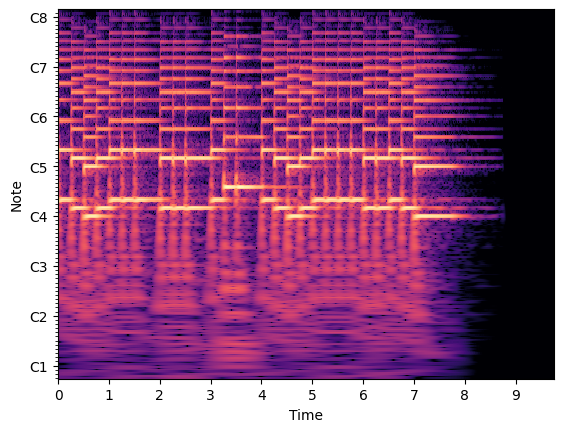

In [129]:
librosa.display.specshow(X_test, sr=sr, hop_length=hop_length,
                            x_axis='time', y_axis='cqt_note',
                            fmin=fmin, bins_per_octave=bins_per_octave,
                            cmap='magma')


In [130]:

def create_sliding_windows(cqt, window_size=9, stride=1):
    pad = window_size // 2  # pad equally on both sides
    cqt_padded = np.pad(cqt, ((0, 0), (pad, pad)), mode='edge')  # pad only time axis
    num_time_bins = cqt.shape[1]

    windows = np.array([
        cqt_padded[:, i:i + window_size]  # shape: (267, window_size)
        for i in range(0, num_time_bins, stride)
    ])
    
    return windows[..., np.newaxis]  # shape: (1000, 267, 9, 1)


X_input = create_sliding_windows(X_test, window_size=9, stride=1)  # (num_windows, 267, 9, 1)
print("Sliding Window X_input Shape:", X_input.shape)

Sliding Window X_input Shape: (978, 267, 9, 1)


In [131]:
predict = model.predict(X_input)
print("Output size : ", predict.shape)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Output size :  (978, 128)


In [132]:
import pretty_midi
import numpy as np

def model_output_to_midi(output, sr=22050, hop_length=256, threshold=0.5, filename="model_output.mid"):

    fs = sr / hop_length  # frames per second
    time_per_frame = 1.0 / fs

    # Threshold the output if it's not binary already
    binary_roll = (output > threshold).astype(np.uint8)
    # print("Max value in output:", np.max(output))
    # print("Total active notes:", np.sum(binary_roll))  # should be > 0
    

    # Create MIDI object and instrument
    midi_out = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    # Loop over each pitch (0 to 127)
    for pitch in range(128):
        active = binary_roll[:, pitch]
        # if np.any(active):
        #     print(f"Pitch {pitch} has activity.")
        changes = np.diff(np.pad(active, (1, 1)))
        # for i in range(len(changes)):
        #     if changes[i] :
        #         print(pitch, i , changes[i])
        onsets = np.where(changes == 1)[0]
        offsets = np.where(changes == 255)[0]
        if any(onsets):
            print("onset : ", pitch, onsets)

        if any(offsets):
            print("offset : ", offsets)
        

        # print(changes, onsets, offsets)

        for start_idx, end_idx in zip(onsets, offsets):
            start = start_idx * time_per_frame
            end = end_idx * time_per_frame
            note = pretty_midi.Note(velocity=100, pitch=pitch, start=start, end=end)
            instrument.notes.append(note)
            print(pitch, start_idx, end_idx)
    midi_out.instruments.append(instrument)
    midi_out.write(filename)
    print(f"MIDI file saved as: {filename}")


In [133]:
model_output_to_midi(predict, filename="yyy.mid")

onset :  60 [ 53 454 705 826]
offset :  [ 73 474 821 869]
60 53 73
60 454 474
60 705 821
60 826 869
onset :  62 [ 31  79 203 226 251 430 481 605 627 681]
offset :  [ 48  98 225 250 298 449 499 626 649 699]
62 31 48
62 79 98
62 203 225
62 226 250
62 251 298
62 430 449
62 481 499
62 605 626
62 627 649
62 681 699
onset :  64 [  2 106 304 403 507 577 656]
offset :  [ 23 198 324 425 575 599 675]
64 2 23
64 106 198
64 304 324
64 403 425
64 507 575
64 577 599
64 656 675
onset :  67 [330 353]
offset :  [348 398]
67 330 348
67 353 398
MIDI file saved as: yyy.mid


In [115]:
midi_path = r'C:\Users\napat\Documents\GitHub\Open-topic-Music-Transcribe-\library_test\Mary.mid'
midi_data = pretty_midi.PrettyMIDI(midi_path)
fs_pianoroll = sr / hop_length  # Frame rate to match CQT
piano_roll = midi_data.get_piano_roll(fs=fs_pianoroll)

In [ ]:
piano_roll.shape

(128, 776)

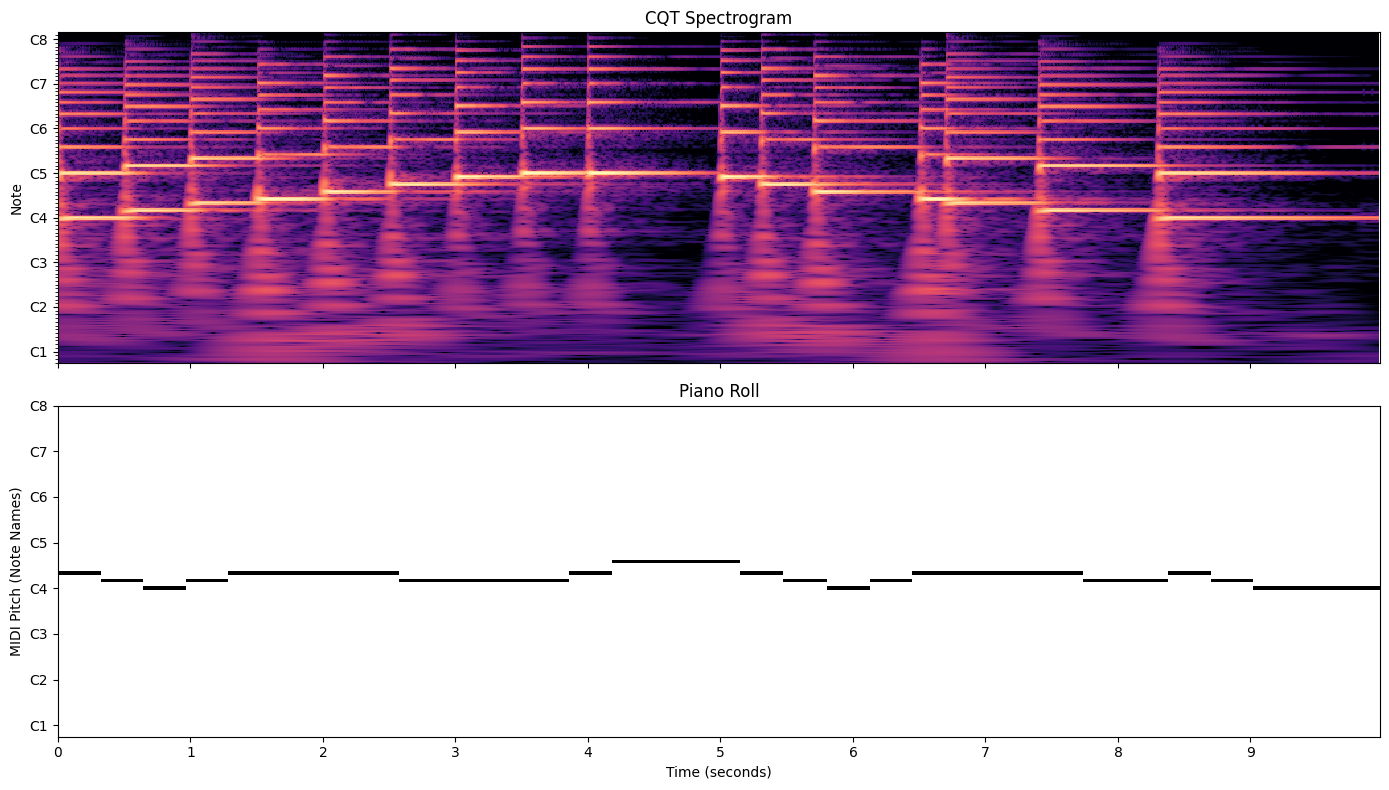

In [116]:
import matplotlib.pyplot as plt
pitch_min = 21    # A0
pitch_max = 108   # C8
duration_sec = X_test.shape[1] * hop_length / sr

# Plot setup
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# === Plot CQT ===
librosa.display.specshow(
    X_test,
    sr=sr,
    hop_length=hop_length,
    x_axis='s',                  # <--- force time in seconds
    y_axis='cqt_note',
    fmin=fmin,
    bins_per_octave=bins_per_octave,
    cmap='magma',
    ax=axs[0]
)
axs[0].set_title("CQT Spectrogram")
axs[0].label_outer()  # hide x-label

# === Plot Piano Roll ===
pitch_min = 21
pitch_max = 108

axs[1].imshow(
    piano_roll[pitch_min:pitch_max+1, :],
    aspect='auto',
    origin='lower',
    cmap='gray_r',
    interpolation='nearest',
    extent=[0, duration_sec, pitch_min, pitch_max]
)

axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('MIDI Pitch (Note Names)')
axs[1].set_title('Piano Roll')
axs[1].set_ylim(pitch_min, pitch_max)

# Label only natural C notes
c_notes = [n for n in range(pitch_min, pitch_max+1)
           if pretty_midi.note_number_to_name(n).startswith('C') and '#' not in pretty_midi.note_number_to_name(n)]
axs[1].set_yticks(c_notes)
axs[1].set_yticklabels([pretty_midi.note_number_to_name(n) for n in c_notes])

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.patches as mpatches

def get_binary_roll(pr, threshold=0):
    return (pr > threshold).astype(np.int8)

def classify_notes(gt, pred):
    TP = (gt == 1) & (pred == 1)
    FN = (gt == 1) & (pred == 0)
    FP = (gt == 0) & (pred == 1)
    return TP, FN, FP

def align_pianorolls(pr1, pr2):
    max_len = max(pr1.shape[1], pr2.shape[1])
    pr1_aligned = np.pad(pr1, ((0, 0), (0, max_len - pr1.shape[1])), mode='constant')
    pr2_aligned = np.pad(pr2, ((0, 0), (0, max_len - pr2.shape[1])), mode='constant')
    return pr1_aligned, pr2_aligned

def compute_difference(pr1, pr2):
    return np.abs(pr1 - pr2)  # absolute difference

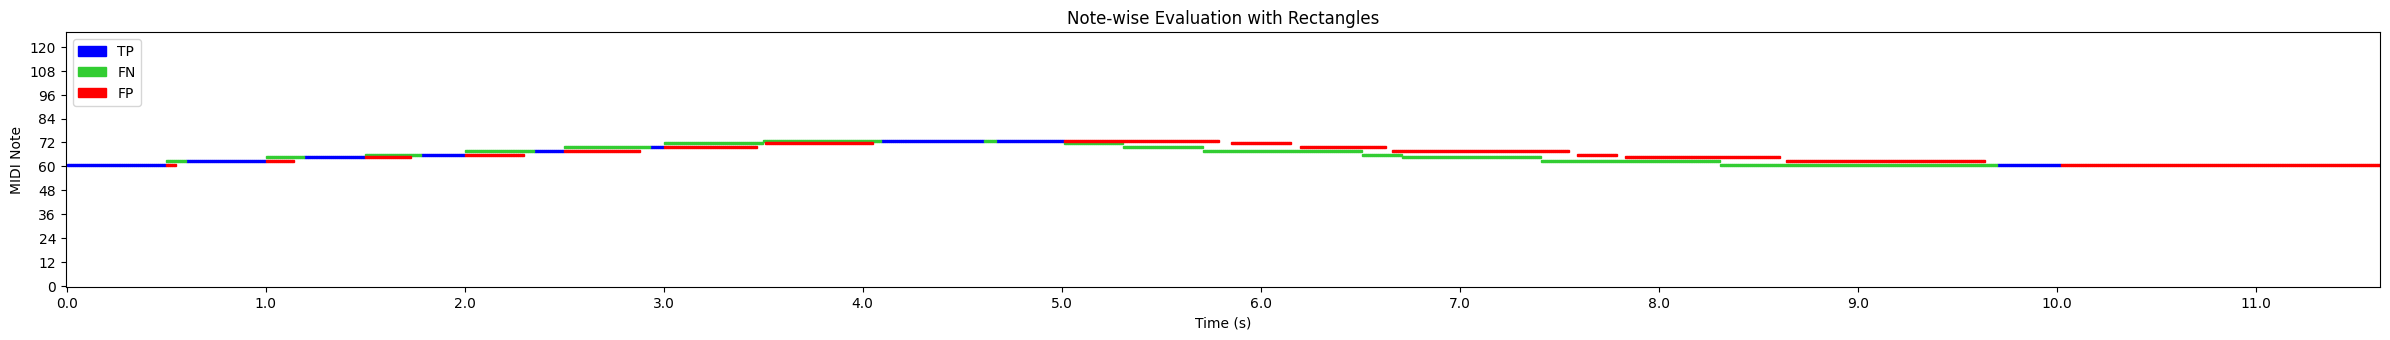

In [ ]:



midi_1 = r'gen_piano\custom_sequence.mid'
midi_data_1 = pretty_midi.PrettyMIDI(midi_1)
midi_2 = r'Fixed_scale_v4_100e_54b.mid'
midi_data_2 = pretty_midi.PrettyMIDI(midi_2)

fs_pianoroll = sr / hop_length  # Frame rate to match CQT
piano_roll_1 = midi_data_1.get_piano_roll(fs=fs_pianoroll)
piano_roll_2 = midi_data_2.get_piano_roll(fs=fs_pianoroll)

m1, m2 = align_pianorolls(piano_roll_1, piano_roll_2)
diff = compute_difference(m1, m2)

fs = sr / hop_length  # your sampling rate/hop setup
pr1 = midi_data_1.get_piano_roll(fs=fs)
pr2 = midi_data_2.get_piano_roll(fs=fs)

pr1_bin = get_binary_roll(pr1)
pr2_bin = get_binary_roll(pr2)

m1_bin, m2_bin = align_pianorolls(pr1_bin, pr2_bin)
TP, FN, FP = classify_notes(m1_bin, m2_bin)



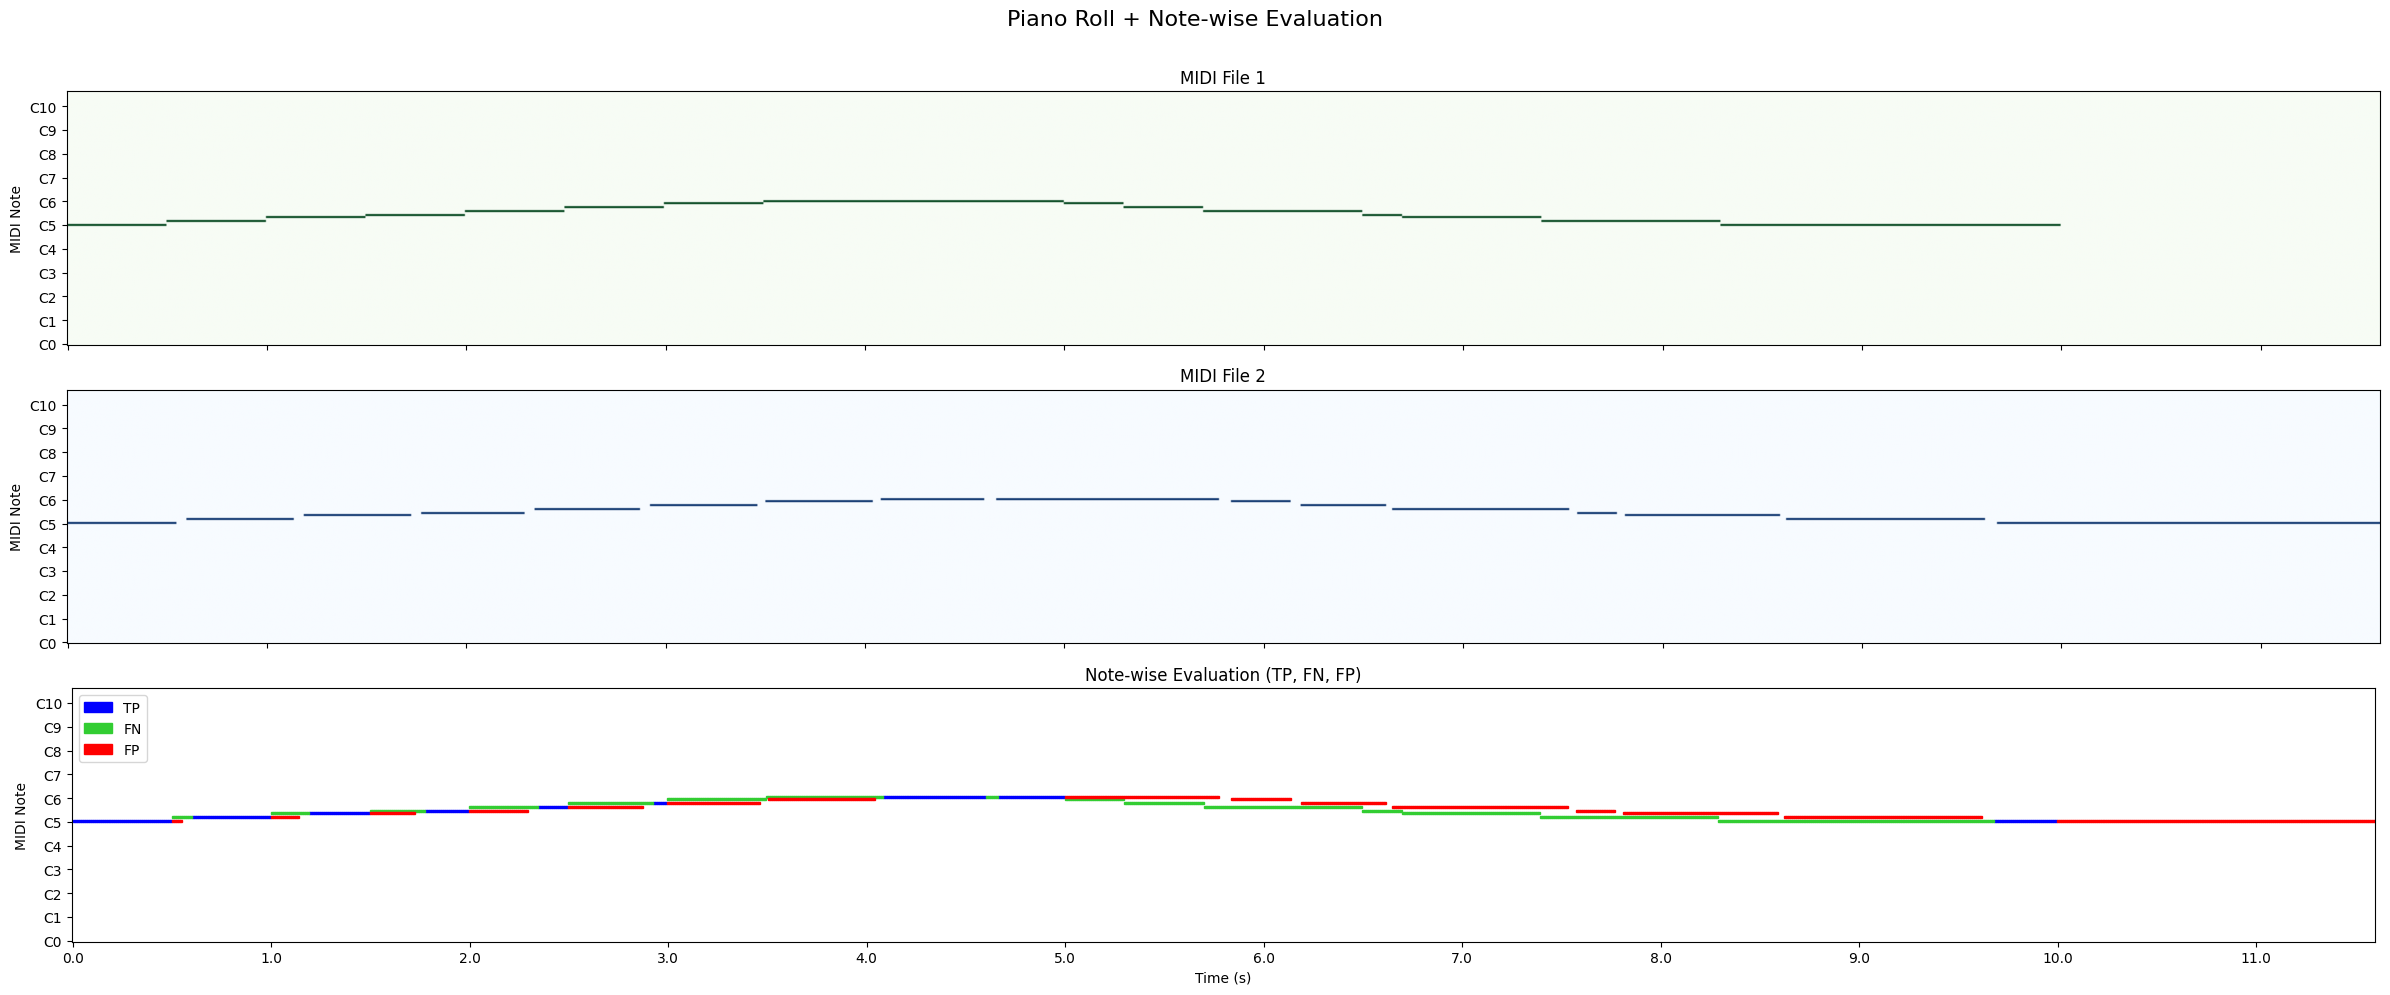

In [196]:
def plot_full_comparison(pr1, pr2, TP, FN, FP, fs=100, title="Piano Roll + Note-wise Evaluation"):
    fig, axs = plt.subplots(3, 1, figsize=(24, 10), sharex=True)

    time_len = pr1.shape[1]
    xticks = np.arange(0, time_len, fs)
    xtick_labels = [f"{x/fs:.1f}" for x in xticks]
    yticks = np.arange(0, 128, 12)
    ylabels = [f'C{i}' for i in range(11)]

    # --- 1. First Piano Roll
    axs[0].imshow(pr1, aspect='auto', origin='lower', cmap='Greens')
    axs[0].set_yticks(yticks)
    axs[0].set_yticklabels(ylabels)
    axs[0].set_title("MIDI File 1")
    axs[0].set_ylabel("MIDI Note")
    axs[0].set_xticks(xticks)
    axs[0].set_xticklabels(xtick_labels)

    # --- 2. Second Piano Roll
    axs[1].imshow(pr2, aspect='auto', origin='lower', cmap='Blues')
    axs[1].set_yticks(yticks)
    axs[1].set_yticklabels(ylabels)
    axs[1].set_title("MIDI File 2")
    axs[1].set_ylabel("MIDI Note")
    axs[1].set_xticks(xticks)
    axs[1].set_xticklabels(xtick_labels)

    # --- 3. Note-wise Evaluation with Rectangles
    axs[2].imshow(np.ones_like(TP), cmap="gray_r", origin="lower")  # white background
    for matrix, color in zip([TP, FN, FP], ['blue', 'limegreen', 'red']):
        y, x = np.where(matrix)
        for xi, yi in zip(x, y):
            rect = mpatches.Rectangle((xi, yi), 1, 1, color=color)
            axs[2].add_patch(rect)

    axs[2].set_yticks(yticks)
    axs[2].set_yticklabels(ylabels)
    axs[2].set_title("Note-wise Evaluation (TP, FN, FP)")
    axs[2].set_xlabel("Time (s)")
    axs[2].set_ylabel("MIDI Note")
    axs[2].set_xticks(xticks)
    axs[2].set_xticklabels(xtick_labels)

    # Legend
    patches = [
        mpatches.Patch(color='blue', label='TP'),
        mpatches.Patch(color='limegreen', label='FN'),
        mpatches.Patch(color='red', label='FP')
    ]
    axs[2].legend(handles=patches, loc='upper left')

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
plot_full_comparison(m1_bin, m2_bin, TP, FN, FP, fs)
